# Life-Cycle Labor Supply with Children

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb
import os, pandas as pd, pickle, math

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import os 
slides = False

In [2]:
# load local model file and initialize model class
from DynLaborFertModel import DynLaborFertModelClass
model = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3}) # set a few number of periods.

par = model.par
sol = model.sol
sim = model.sim

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
hours = 'h'
child = 'n'
assets = 'a'
capital = 'k'
spouse = 's'

In [7]:
figpath = r"/Users/bruger/Desktop/Household behavior/HouseholdBehaviorCourse-1/05/Figures"

# Question 1
In the following of code, I solve and simulate the model for a different number of beta_1 values. I calculate mean optimal hours in time relevant to brith and save these for each of the beta_1 values. Afterwards, I plot the mean values. 



In [18]:
beta_1_list = [0.01, 0.02, 0.03, 0.04, 0.05]
m_hours_b = {}

for beta_1 in beta_1_list:
    model.par.beta_1 = beta_1
    model.solve()
    model.simulate()

    birth = np.zeros(sim.n.shape,dtype=np.int_)
    birth[:,1:] = (sim.n[:,1:] - sim.n[:,:-1]) > 0 #G enerates an 1D-array array where 1-values indicate that a birth occurred between two periods 
    
    periods = np.tile([t for t in range(par.simT)],(par.simN,1))
    time_of_birth = np.max(periods * birth, axis=1)
    
    I = time_of_birth>0
    time_of_birth[~I] = -1000 # never has a child
    time_of_birth = np.transpose(np.tile(time_of_birth , (par.simT,1)))
    
    time_since_birth = periods - time_of_birth

    min_time = -8
    max_time = 8
    event_grid = np.arange(min_time,max_time+1)

    event_hours = np.nan + np.zeros(event_grid.size)
    for t,time in enumerate(event_grid):
        event_hours[t] = np.mean(sim.h[time_since_birth==time])

    # relative to period before birth
    event_hours_rel = event_hours - event_hours[event_grid==-1]

    m_hours_b[beta_1] = event_hours
    m_hours_b[(beta_1, 'rel')] = event_hours_rel

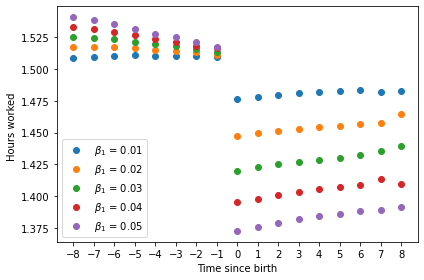

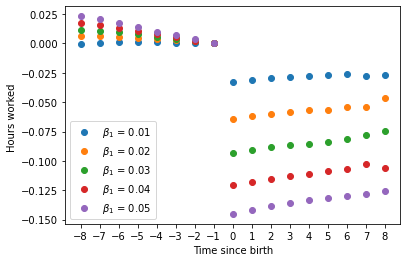

In [22]:
fig, ax = plt.subplots()
for beta_1 in beta_1_list:
    ax.scatter(event_grid,m_hours_b[(beta_1)],label=fr"$\beta_1$ = {beta_1}")
ax.set(xlabel='Time since birth',ylabel=f'Hours worked ',xticks=event_grid)
ax.legend();
fig.tight_layout();
if slides:
    fig.savefig(figpath+ r"/beta_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(figpath+ r"/beta.pdf",edgecolor='k')

fig, ax = plt.subplots()
for beta_1 in beta_1_list:
    ax.scatter(event_grid,m_hours_b[(beta_1),'rel'],label=fr"$\beta_1$ = {beta_1}")
ax.set(xlabel='Time since birth',ylabel=f'Hours worked ',xticks=event_grid)
ax.legend();
if slides:
    fig.savefig(figpath+ r"/betarel_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(figpath+ r"/betarel.pdf",edgecolor='k')

# Question 2


1) Calculates Marshallian elasticity (ela_M). I do the following steps:

a) I run a loop in which I solve the the model for tau=0.1(baseline) and tau=0.11 (new).
   I save average hours worked over the time period under both regimes.
   This allows me to compare hours worked under the initial regime where the income tax is 10 pct. with the new regime where the income tax i 11 pct.

b) I calculate the Marshallian elasticity by subtracting mean hours under old regime from mean hours under new regime and dividing by hours under old regime. This provides the pct. change in average hours for each time period following a 1 pct. increase in the marginal tax. 

c) I plot the Marshallian elasticity over the time period. 



In [9]:
# Solve model for tau = 0.1 (baseline) and tau=0.11 
tau_list = [0.1,0.11]
m_hours = {}

for tau in tau_list:
    model.par.tau = tau
    model.par.beta_1 = 0.03
    model.par.spouse = 0.
    model.par.theta = 0.
    model.solve()
    model.simulate()
    m_hours[tau] = np.mean(getattr(sim,hours),axis=0).tolist()

In [10]:
ela_M = (np.subtract(m_hours[0.11], m_hours[0.1]) / m_hours[0.1]) * 100

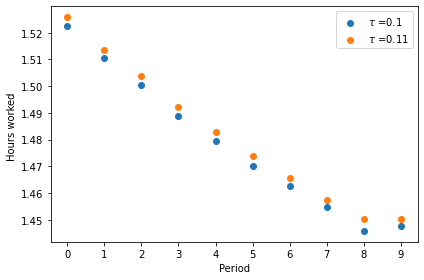

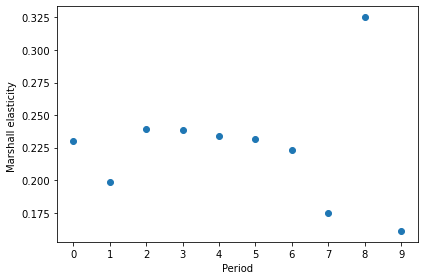

In [11]:
# 1) Plot hours worked for tau=0.10 and tau=0.11 
# 2) Plot Marshall elasticity

periods = np.arange(0, par.T)
fig, ax = plt.subplots()
for tau in tau_list:
    ax.scatter(periods,m_hours[tau],label=fr"$\tau$ ={tau}")
ax.set(xlabel='Period',ylabel=f'Hours worked ',xticks=periods)
ax.legend();
fig.tight_layout();
if slides:
    fig.savefig(figpath+ r"/hours_tau_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(figpath+ r"/hours_tau.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods,ela_M)
ax.set(xlabel='Period',ylabel=f'Marshall elasticity ',xticks=periods);
fig.tight_layout();
if slides:
    fig.savefig(figpath+ r"/Marshall_tau_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(figpath+ r"/Marshall_tau.pdf",edgecolor='k')

2) Determine Marshallian elasticity for individuals with and without children. 

a) I run a loop in which I solve the model under the two tax regimes, conditional on whether there is a child present. 
First, I back out hours for individuals with and without children in each period. 
Second, I calculate average hours for individuals with and without children in each period. 

b) I take period 0 as bo individuals have children in period 0. 

c) I calcilate the elasticities conditional on having children. As before I by subtract mean hours under old regime from mean hours under new regime and dividing by hours under old regime. This provides the pct. change in average hours for each time period following a 1 pct. increase in the marginal tax. 

d) I plot hours worked over the time period for persons with children and without children. 
I consider only period 1-9 as there are no individuals who have children in period 0. 

e) I plot the Marshallian elasticity for persons with and without children. 
I consider only period 1-9 as there are no individuals who have children in period 0. 

In [4]:
tau_list = [0.1,0.11]

m_hours_c0 = [[] for _ in range(len(tau_list))]  # create a list of empty lists to store mean hours for c=0 for each period t
m_hours_c1 = [[] for _ in range(len(tau_list))]  # create a list of empty lists to store mean hours for c=1 for each period t

for i, tau in enumerate(tau_list):
    model.par.tau = tau
    model.par.beta_1 = 0.03
    model.par.spouse = 0. 
    model.par.theta = 0.
    model.solve()
    model.simulate()

    for t in range(par.simT):
        hours_c0_t = []  # create a temporary list to store hours for c=0 for period t
        hours_c1_t = []  # create a temporary list to store hours for c=1 for  period t
        for j in range(par.simN):
            if getattr(sim, child)[j, t] == 0:
                hours_c0_t.append(getattr(sim, hours)[j, t])
            elif getattr(sim, child)[j, t] == 1:
                hours_c1_t.append(getattr(sim, hours)[j, t])
        if hours_c0_t:  # check if the temporary list for c=0 is not empty
            m_hours_c0[i].append(np.mean(hours_c0_t))  # calculate mean hours for c=0 in current period t and append to list
        else:
            m_hours_c0[i].append(None)  # if no persons with c=0 are present in current period t, append None to list
        if hours_c1_t:  # check if the temporary list for c=1 is not empty
            m_hours_c1[i].append(np.mean(hours_c1_t))  # calculate mean hours for c=1 in current period and append to list
        else:
            m_hours_c1[i].append(None)  # if no persons with c=1 are present in current period, append None to list

In [5]:
m_hours_c0 = [i[1:] for i in m_hours_c0] # take out the first obs in each dimension of 2D-list
m_hours_c1 = [i[1:] for i in m_hours_c1] # take out the first obs. 

ela_M_c0= (np.subtract(m_hours_c0[1], m_hours_c0[0]) / m_hours_c0[0]) * 100
ela_M_c1= (np.subtract(m_hours_c1[1], m_hours_c1[0]) / m_hours_c1[0]) * 100

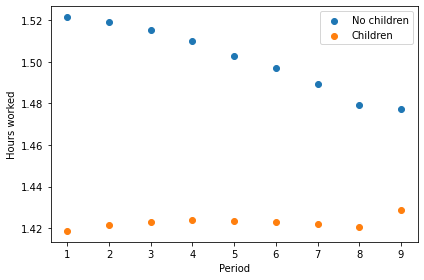

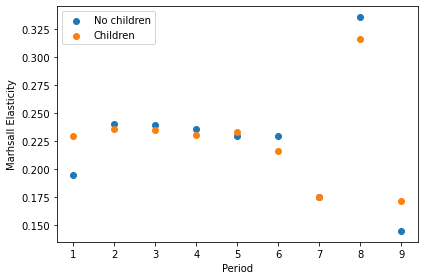

In [8]:
# 1) Plot hours worked for individuals without and with children 
# 2) Plot Marshall elasticity for individuals without and with children

periods = np.arange(1, 10)

fig, ax = plt.subplots()
ax.scatter(periods, m_hours_c0[0], label='No children')
ax.scatter(periods, m_hours_c1[0], label='Children')
ax.set(xlabel='Period', ylabel='Hours worked', xticks=periods)
ax.legend()
fig.tight_layout();
if slides:
    fig.savefig(figpath+ r"/hours_c_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(figpath+ r"/hours_c.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, ela_M_c0, label='No children')
ax.scatter(periods, ela_M_c1, label='Children')
ax.set(xlabel='Period', ylabel='Marhsall Elasticity', xticks=periods)
ax.legend()
fig.tight_layout();
if slides:
    fig.savefig(figpath+ r"/Marshall_c_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(figpath+ r"/Marshall_c.pdf",edgecolor='k')



# Question 3

For question 3 and 4 I make the following alterations in the py-file:

a) I add parameters par.spouse = 0. and par.theta = 0. 

b) I call this when I want to solve the model with a spouse and with child costs. 

c) I add spouse = par.spouse*(0.1+0.01*par.T) to def cons_last.

d) I add spouse = par.spouse*(0.1+0.01*t) to def value_of_choice.

e) I add theta = par.theta*0.05*kids to both def cons_last and value_of_choice.

f) I also add par.theta*kids to hours_min as child costs are now part of the lower bound for how many hours needs to be worked.

In the run the model for values of par.spouse = 0,1 and par.theta = 0,1 and the two tau values to determine elasticities. 

In [12]:
s_list = [0., 1.]
tau_list = [0.1, 0.11]
m_hours_s_tau = {}

for s in s_list:
    m_hours_tau = {}
    model.par.spouse = s
    model.par.theta = 0.
    model.par.beta_1 = 0.03

    for tau in tau_list:
        model.par.tau = tau
        model.solve()
        model.simulate()
        m_hours_tau[tau] = np.mean(getattr(sim, hours), axis=0).tolist()
    
    m_hours_s_tau[s] = m_hours_tau

m_hours_s0 = m_hours_s_tau[0] # Get hours for individuals without a spouse
m_hours_s1 = m_hours_s_tau[1] # Get hours for individuals with a spouse

# Calculate marshall elasticity or individuals without and with a spouse
ela_M_s0= (np.subtract(m_hours_s0[0.11], m_hours_s0[0.1]) / m_hours_s0[0.1]) * 100
ela_M_s1= (np.subtract(m_hours_s1[0.11], m_hours_s1[0.1]) / m_hours_s1[0.1]) * 100

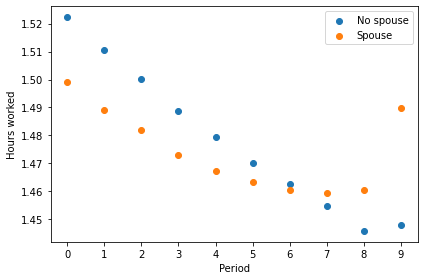

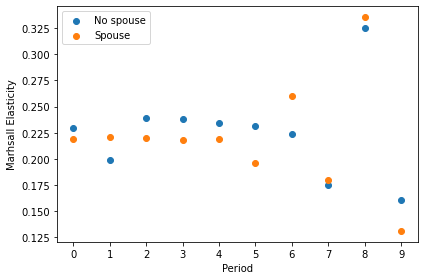

In [13]:
# 1) Plot hours worked for individuals without and with spouse 
# 2) Plot Marshall elasticity for individuals without and with spouse

periods = np.arange(0, 10)

fig, ax = plt.subplots()
ax.scatter(periods, m_hours_s0[0.1], label='No spouse')
ax.scatter(periods, m_hours_s1[0.1], label='Spouse')
ax.set(xlabel='Period', ylabel='Hours worked', xticks=periods)
ax.legend()
fig.tight_layout();
if slides:
    fig.savefig(figpath+ r"/Hours_s_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(figpath+ r"/Hours_s.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, ela_M_s0, label='No spouse')
ax.scatter(periods, ela_M_s1, label='Spouse')
ax.set(xlabel='Period', ylabel='Marhsall Elasticity', xticks=periods)
ax.legend()
fig.tight_layout();
if slides:
    fig.savefig(figpath+ r"/Marshall_s_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(figpath+ r"/Marshall_s.pdf",edgecolor='k')

# Question 4

In [25]:
tau_list = [0.1,0.11]

m_hours_c0th = [[] for _ in range(len(tau_list))]  # create a list of empty lists to store mean hours for c=0 for each period t
m_hours_c1th = [[] for _ in range(len(tau_list))]  # create a list of empty lists to store mean hours for c=1 for each period t

for i, tau in enumerate(tau_list):
    model.par.tau = tau
    model.par.theta = 1.
    model.par.spouse = 0.
    model.par.beta_1 = 0.03
    model.solve()
    model.simulate()

    for t in range(par.simT):
        hours_c0th_t = []  # create a temporary list to store hours for c=0 for period t
        hours_c1th_t = []  # create a temporary list to store hours for c=1 for  period t
        for j in range(par.simN):
            if getattr(sim, child)[j, t] == 0:
                hours_c0th_t.append(getattr(sim, hours)[j, t])
            elif getattr(sim, child)[j, t] == 1:
                hours_c1th_t.append(getattr(sim, hours)[j, t])
        if hours_c0th_t:  # check if the temporary list for c=0 is not empty
            m_hours_c0th[i].append(np.mean(hours_c0th_t))  # calculate mean hours for c=0 in current period t and append to list
        else:
            m_hours_c0th[i].append(None)  # if no persons with c=0 are present in current period t, append None to list
        if hours_c1th_t:  # check if the temporary list for c=1 is not empty
            m_hours_c1th[i].append(np.mean(hours_c1th_t))  # calculate mean hours for c=1 in current period and append to list
        else:
            m_hours_c1th[i].append(None)  # if no persons with c=1 are present in current period, append None to list

In [28]:
m_hours_c0th = [i[1:] for i in m_hours_c0th] # take out the first obs in each dimension of 2D-list
m_hours_c1th = [i[1:] for i in m_hours_c1th] # take out the first obs. 

ela_M_c0th= (np.subtract(m_hours_c0th[1], m_hours_c0th[0]) / m_hours_c0th[0]) * 100
ela_M_c1th= (np.subtract(m_hours_c1th[1], m_hours_c1th[0]) / m_hours_c1th[0]) * 100

In [31]:
print(m_hours_c0th)
print(m_hours_c0)
# should be the same: mean hours for people without children in new code (with child costs) is the same as mean hours for people without children
# in old code (without child costs)

[[1.5236983097053731, 1.5208260563145182, 1.51638883890754, 1.510740325834416, 1.5025256399046285, 1.496102290172383, 1.4871932997418411, 1.4791563506493932, 1.472323446471313], [1.5269879965709072, 1.524406918525067, 1.519934986789437, 1.514110861714665, 1.5059309763991278, 1.4994739433207445, 1.4901910279254609, 1.4841333487704829, 1.4736843479230675]]
[[1.5214584785933007, 1.518875347785775, 1.5150642454716883, 1.5101190278346948, 1.502597695352398, 1.4968043057121807, 1.4892819893892637, 1.4792367923770715, 1.477223048594851], [1.524431324136806, 1.5225235336066913, 1.518688765507543, 1.513679873315937, 1.5060531371398922, 1.5002367979522182, 1.4918931187842757, 1.484205124107379, 1.479363462907708]]


In [32]:
print(m_hours_c1th)
print(m_hours_c1)
# should be different: mean hours for people with children in new code (with child costs) should be different 
# that mean hours for people with children in old code (without child costs)

[[1.425982762966555, 1.4283862042449265, 1.4288494021799125, 1.4289186060224497, 1.427298654162328, 1.4243014417280369, 1.4217741703763542, 1.423462119490059, 1.4156153540553853], [1.4293299792931458, 1.4317543906800454, 1.432182397284061, 1.4321964321266036, 1.430568811898365, 1.4276611332465243, 1.4251730721422535, 1.4276098710813008, 1.4169167917497436]]
[[1.418625612917073, 1.4217903394079991, 1.423108267176229, 1.4241479573579199, 1.4234222303019555, 1.4227790109526601, 1.4220612975832578, 1.4204742839299158, 1.4287766636937027], [1.4218856445916281, 1.425146767092053, 1.4264605205321117, 1.4274267115497616, 1.4267454918001028, 1.4258598988221607, 1.4245497935459708, 1.4249739660217644, 1.4312303955430519]]


In [19]:
print(m_hours)
print(m_hours_s0)
#should be the same: mean hours for people without spouse in new code (with pouse) is the same as mean hours for people in olc code 

{0.1: [1.5223627055245443, 1.5106610276973116, 1.5003321111856058, 1.4886728797008777, 1.4794273556744726, 1.4702941056118395, 1.4625305942385323, 1.4547305538009687, 1.4457421625622058, 1.4477676465749592], 0.11: [1.5258627603391044, 1.513664027784588, 1.5039245712024074, 1.492219259199586, 1.4828874945654322, 1.4736956178412588, 1.4658002936550154, 1.4572786496117627, 1.450443363998574, 1.4500985579499928]}
{0.1: [1.5223627055245443, 1.5106610276973116, 1.5003321111856058, 1.4886728797008777, 1.4794273556744726, 1.4702941056118395, 1.4625305942385323, 1.4547305538009687, 1.4457421625622058, 1.4477676465749592], 0.11: [1.5258627603391044, 1.513664027784588, 1.5039245712024074, 1.492219259199586, 1.4828874945654322, 1.4736956178412588, 1.4658002936550154, 1.4572786496117627, 1.450443363998574, 1.4500985579499928]}


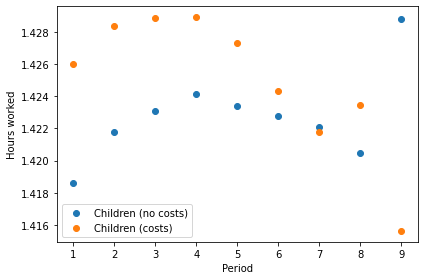

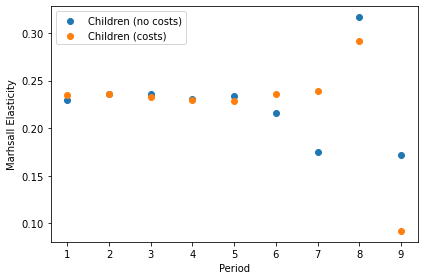

In [33]:
periods = np.arange(1, 10)

fig, ax = plt.subplots()
ax.scatter(periods, m_hours_c1[0], label='Children (no costs)')
ax.scatter(periods, m_hours_c1th[0], label='Children (costs)')
ax.set(xlabel='Period', ylabel='Hours worked', xticks=periods)
ax.legend()
fig.tight_layout();
if slides:
    fig.savefig(figpath+ r"/Hours_cth_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(figpath+ r"/Hours_cth.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, ela_M_c1, label='Children (no costs)')
ax.scatter(periods, ela_M_c1th, label='Children (costs)')
ax.set(xlabel='Period', ylabel='Marhsall Elasticity', xticks=periods)
ax.legend()
fig.tight_layout();
if slides:
    fig.savefig(figpath+ r"/Marshall_cth_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(figpath+ r"/Marshall_cth.pdf",edgecolor='k')

# Question 6

Note that in order to run this part of the code, there is a need to change the py-file.
Specifically, one should comment in the green parts for "married" in def simulate. (line 280-284 and 292-296)
moreover, the birth part needs to be commented out. (line 286-290)